In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from statsmodels.tsa.seasonal import STL

# Load dataset
file_path = 'D:/SANG/Do An Tot Nghiep/dataset1/processed_job_data_human-readable_date.csv'
data = pd.read_csv(file_path)

# Convert 'time' to datetime format
data['time'] = pd.to_datetime(data['time'])

# Clean 'city' and 'job' columns
data['city'] = data['city'].astype(str).str.strip()
data['job'] = data['job'].astype(str).str.strip().str.upper()

# Debug: Check for NaN values in 'job' column before filtering
print(f"\n🔹 Initial NaN count in 'job' column: {data['job'].isna().sum()}")

# Drop NaN values in 'job'
data = data.dropna(subset=['job'])

# Identify top 20 jobs by total job_counting
job_counts = data.groupby('job')['job_counting'].sum().nlargest(20)
print("\n🔹 Top 20 Jobs by Job Counting:")
print(job_counts)

top_jobs = job_counts.index.tolist()
data = data[data['job'].isin(top_jobs)].copy()

# One-hot encode city
city_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
city_encoded = city_encoder.fit_transform(data[['city']])
city_encoded_df = pd.DataFrame(city_encoded, columns=city_encoder.get_feature_names_out(['city']))

data.drop(columns=['city'], inplace=True)
data = pd.concat([data, city_encoded_df], axis=1)

# One-hot encode job
job_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
job_encoded = job_encoder.fit_transform(data[['job']])
job_encoded_df = pd.DataFrame(job_encoded, columns=job_encoder.get_feature_names_out(['job']))

data.drop(columns=['job'], inplace=True)
data = pd.concat([data, job_encoded_df], axis=1)

data.set_index('time', inplace=True)

# Debug: Check if 'job_nan' column still exists
print("\n🔹 Checking for 'job_nan' column:")
print([col for col in data.columns if 'job_nan' in col])

# Resample job_counting
data_numerical = data[['job_counting']].resample('ME').sum().fillna(0)
data_categorical = data.drop(columns=['job_counting']).resample('ME').max().fillna(0)  # Fix applied here
data = pd.concat([data_numerical, data_categorical], axis=1)

# Debug: Check if 'job_BACKEND' and 'job_FRONTEND' exist
debug_jobs = ['job_BACKEND', 'job_FRONTEND']
print("\n🔹 Checking for missing jobs:")
for job in debug_jobs:
    print(f"{job} exists: {job in data.columns}")

# Apply STL Decomposition
stl = STL(data['job_counting'], seasonal=13)
result = stl.fit()
data['trend'] = result.trend
data['seasonal'] = result.seasonal
data['residual'] = result.resid

# Reorder columns
city_columns = [col for col in data.columns if col.startswith('city_')]
job_columns = [col for col in data.columns if col.startswith('job_')]
data = data[city_columns + job_columns + ['trend', 'seasonal', 'residual', 'job_counting']]

# Remove duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

# Data Augmentation with Stability
def augment_data(df, factor=30):
    augmented = []
    for _ in range(factor):
        noise = np.random.normal(0, df['job_counting'].std() * 0.015, df.shape[0])
        augmented_df = df.copy()
        augmented_df['job_counting'] += noise
        augmented_df['job_counting'] = np.maximum(0, augmented_df['job_counting'])
        augmented.append(augmented_df)
    return pd.concat(augmented).sort_index()

data = augment_data(data, 30)

# Create lagged features
look_back = 18
for lag in range(1, look_back + 1):
    data[f'lag_{lag}'] = data['job_counting'].shift(lag)

data.dropna(inplace=True)

# Normalize numerical features
num_cols = ['job_counting', 'trend', 'seasonal', 'residual'] + [f'lag_{i}' for i in range(1, look_back + 1)]

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

# Fit MinMaxScaler ONLY on training data
scaler = MinMaxScaler()
scaler.fit(train_data[num_cols])  

# Transform train and test data separately
train_data[num_cols] = scaler.transform(train_data[num_cols])
test_data[num_cols] = scaler.transform(test_data[num_cols])

# Prepare data for LSTM
def create_dataset(data, look_back=18):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data.iloc[i:i + look_back].values)
        Y.append(data.iloc[i + look_back]['job_counting'])
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Count the number of distinct job samples
job_columns = [col for col in data.columns if col.startswith('job_')]
distinct_job_samples = {col: (data[col] == 1.0).sum() for col in job_columns}

# Print results
print("\n🔹 Number of distinct samples for each job:")
for job, count in distinct_job_samples.items():
    print(f"{job}: {count}")

# Total number of distinct job samples
total_distinct_samples = sum(distinct_job_samples.values())
print(f"\n🔹 Total distinct job samples: {total_distinct_samples}")


🔹 Initial NaN count in 'job' column: 0

🔹 Top 20 Jobs by Job Counting:
job
JAVA                   13520
PHP                     9855
.NET                    8994
TESTER                  5973
FRONTEND                4605
ANDROID                 3586
IOS                     3506
NODEJS                  2142
REACTJS                 1918
PYTHON                  1398
BRSE                    1187
BA                      1043
RUBYONRAILS             1035
HTML/CSS/JAVASCRIPT     1015
C/C++                    990
DEVOPS                   927
REACTNATIVE              729
PM                       720
ANGULARJS                583
BACKEND                  514
Name: job_counting, dtype: int64

🔹 Checking for 'job_nan' column:
['job_nan']

🔹 Checking for missing jobs:
job_BACKEND exists: True
job_FRONTEND exists: True

🔹 Number of distinct samples for each job:
job_counting: 0
job_.NET: 1842
job_ANDROID: 1572
job_ANGULARJS: 390
job_BA: 1542
job_BACKEND: 210
job_BRSE: 810
job_C/C++: 1050
job_DEVOPS: 

d:\SANG\Do An Tot Nghiep\crawl-data\venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 23 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\tansa\AppData\Local\Temp\ipykernel_8620\3341116506.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  missing_dates = pd.date_range(start=last_historical_date + pd.DateOffset(months=1), periods=missing_months, freq='M')


DEBUG: Inputs - City: Đà Nẵng, Job: FRONTEND, Start Date: 2024-01, Steps: 12
DEBUG: One-hot encoding successful.
DEBUG: Using 18 months of historical data from 2018-08-31 00:00:00 to 2020-09-30 00:00:00
DEBUG: Gap detected between 2020-09-30 00:00:00 and 2024-01-01 00:00:00. Predicting for the missing period.


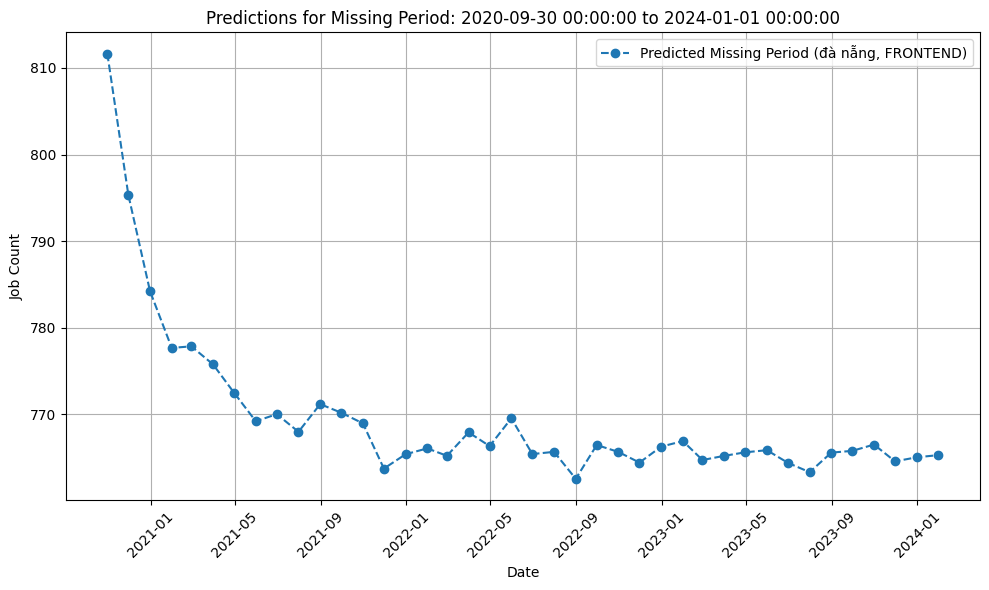

C:\Users\tansa\AppData\Local\Temp\ipykernel_8620\3341116506.py:113: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=start_date, periods=steps, freq='M')


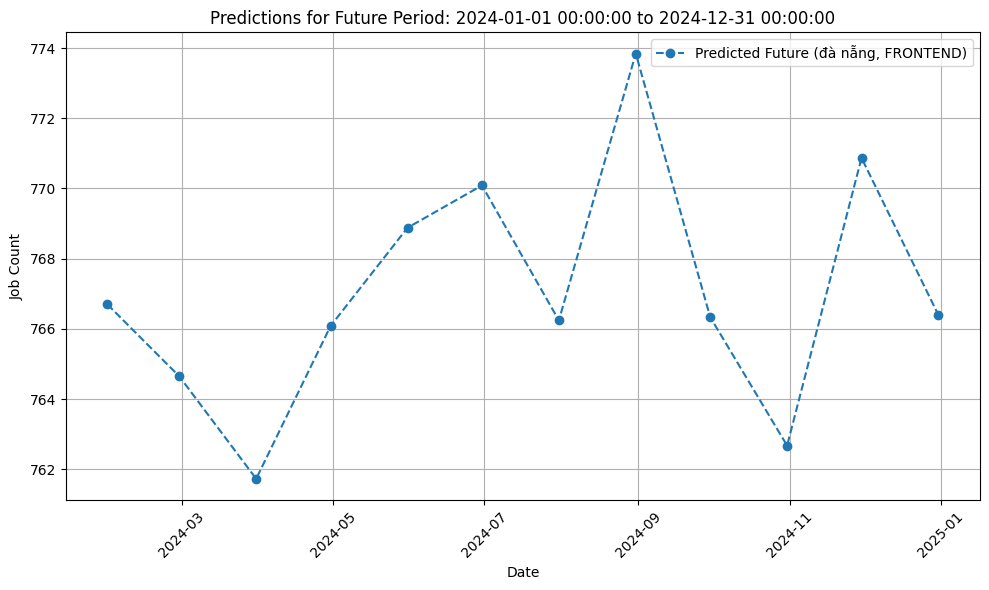

[np.float64(766.6995376716551),
 np.float64(764.6488002785219),
 np.float64(761.7298601955547),
 np.float64(766.0848200964169),
 np.float64(768.8812419901283),
 np.float64(770.0868128715516),
 np.float64(766.2424307070092),
 np.float64(773.8420847088365),
 np.float64(766.3363400871276),
 np.float64(762.6750083551862),
 np.float64(770.8700261776418),
 np.float64(766.3926266248268)]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model
model_path = "D:/SANG/Do An Tot Nghiep/crawl-data/data/DATA PRE-PROCESSING/model/job_trend_forecasting_model.keras"
model = load_model(model_path)

def predict_future(city_name, job_name, start_date, steps=12, add_noise=True):
    print(f"DEBUG: Inputs - City: {city_name}, Job: {job_name}, Start Date: {start_date}, Steps: {steps}")

    city_name = city_name.strip().lower()
    job_name = job_name.strip().upper()

    # Match city & job
    matched_city = next((c for c in city_encoder.categories_[0] if c.strip().lower() == city_name), None)
    matched_job = next((j for j in job_encoder.categories_[0] if j.strip().upper() == job_name), None)

    if matched_city is None or matched_job is None:
        print(f"Error: City '{city_name}' or Job '{job_name}' not found!")
        return

    print("DEBUG: One-hot encoding successful.")

    # Create one-hot vectors
    city_vector = np.zeros(len(city_encoder.categories_[0]))
    city_vector[np.where(city_encoder.categories_[0] == matched_city)[0][0]] = 1

    job_vector = np.zeros(len(job_encoder.categories_[0]))
    job_vector[np.where(job_encoder.categories_[0] == matched_job)[0][0]] = 1

    # **Filter data for the given city & job**
    job_city_filter = (data[f'city_{matched_city}'] == 1) & (data[f'job_{matched_job}'] == 1)
    filtered_data = data[job_city_filter].copy()

    if filtered_data.empty:
        print(f"Error: No historical data found for City '{city_name}' and Job '{job_name}'")
        return

    # Ensure unique timestamps
    filtered_data = filtered_data.groupby(level=0).first()

    # Convert start_date to datetime
    start_date = pd.to_datetime(start_date)

    # **Find closest historical date before start_date**
    filtered_data = filtered_data.sort_index()
    past_data = filtered_data.loc[:start_date]

    if past_data.empty:
        print(f"ERROR: No historical data available before {start_date}. Cannot predict!")
        return

    # **Select the last 'look_back' months before start_date**
    available_data = past_data.iloc[-look_back:].copy()

    # **Fix Missing Data with Interpolation**
    if available_data.shape[0] < look_back:
        print(f"DEBUG: Insufficient data ({available_data.shape[0]} rows), using interpolation.")
        available_data = available_data.resample('M').interpolate(method='linear').iloc[-look_back:]

    print(f"DEBUG: Using {available_data.shape[0]} months of historical data from {available_data.index[0]} to {available_data.index[-1]}")

    # **Normalize historical data**
    available_data[num_cols] = scaler.transform(available_data[num_cols])

    # **Check if there is a gap between the last historical data and start_date**
    last_historical_date = available_data.index[-1]
    if last_historical_date < start_date:
        print(f"DEBUG: Gap detected between {last_historical_date} and {start_date}. Predicting for the missing period.")

        # Calculate the number of months to predict for the missing period
        missing_months = (start_date.year - last_historical_date.year) * 12 + (start_date.month - last_historical_date.month)
        missing_dates = pd.date_range(start=last_historical_date + pd.DateOffset(months=1), periods=missing_months, freq='M')

        # Predict for the missing period
        missing_predictions = []
        for _ in range(missing_months):
            input_data = available_data.values
            input_data = np.expand_dims(input_data, axis=0)

            # Predict
            pred = model.predict(input_data, verbose=0)[0, 0]

            # **Fix: Ensure Proper Inverse Scaling**
            denormalized_pred = scaler.inverse_transform([[pred] + [0] * (len(num_cols) - 1)])[0, 0]

            # **Add Noise to Prevent Over-Smoothing**
            if add_noise:
                denormalized_pred += np.random.normal(0, 2)

            missing_predictions.append(denormalized_pred)

            # Shift input for next prediction
            available_data.iloc[:-1] = available_data.iloc[1:].values
            available_data.iloc[-1, 0] = pred

        # Plot predictions for the missing period
        plt.figure(figsize=(10, 6))
        plt.plot(missing_dates, missing_predictions, marker='o', linestyle='dashed', label=f'Predicted Missing Period ({city_name}, {job_name})')
        plt.xlabel("Date")
        plt.ylabel("Job Count")
        plt.title(f"Predictions for Missing Period: {last_historical_date} to {start_date}")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # **Predict for the requested future period**
    predictions = []
    future_dates = pd.date_range(start=start_date, periods=steps, freq='M')

    for _ in range(steps):
        input_data = available_data.values
        input_data = np.expand_dims(input_data, axis=0)

        # Predict
        pred = model.predict(input_data, verbose=0)[0, 0]

        # **Fix: Ensure Proper Inverse Scaling**
        denormalized_pred = scaler.inverse_transform([[pred] + [0] * (len(num_cols) - 1)])[0, 0]

        # **Add Noise to Prevent Over-Smoothing**
        if add_noise:
            denormalized_pred += np.random.normal(0, 2)

        predictions.append(denormalized_pred)

        # Shift input for next prediction
        available_data.iloc[:-1] = available_data.iloc[1:].values
        available_data.iloc[-1, 0] = pred

    # **Plot Results**
    plt.figure(figsize=(10, 6))
    plt.plot(future_dates, predictions, marker='o', linestyle='dashed', label=f'Predicted Future ({city_name}, {job_name})')
    plt.xlabel("Date")
    plt.ylabel("Job Count")
    plt.title(f"Predictions for Future Period: {start_date} to {future_dates[-1]}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return predictions

# Example Usage
predict_future("Đà Nẵng", "FRONTEND", '2024-01', steps=12)

d:\SANG\Do An Tot Nghiep\crawl-data\venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 23 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\tansa\AppData\Local\Temp\ipykernel_4024\3266537846.py:74: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  missing_dates = pd.date_range(start=last_historical_date + pd.DateOffset(months=1), periods=missing_months, freq='M')


DEBUG: Inputs - City: Đà Nẵng, Job: DEVOPS, Start Date: 2023-06, Steps: 12
DEBUG: One-hot encoding successful.
DEBUG: Using 18 months of historical data from 2018-11-30 00:00:00 to 2020-10-31 00:00:00
DEBUG: Gap detected between 2020-10-31 00:00:00 and 2023-06-01 00:00:00. Predicting for the missing period.


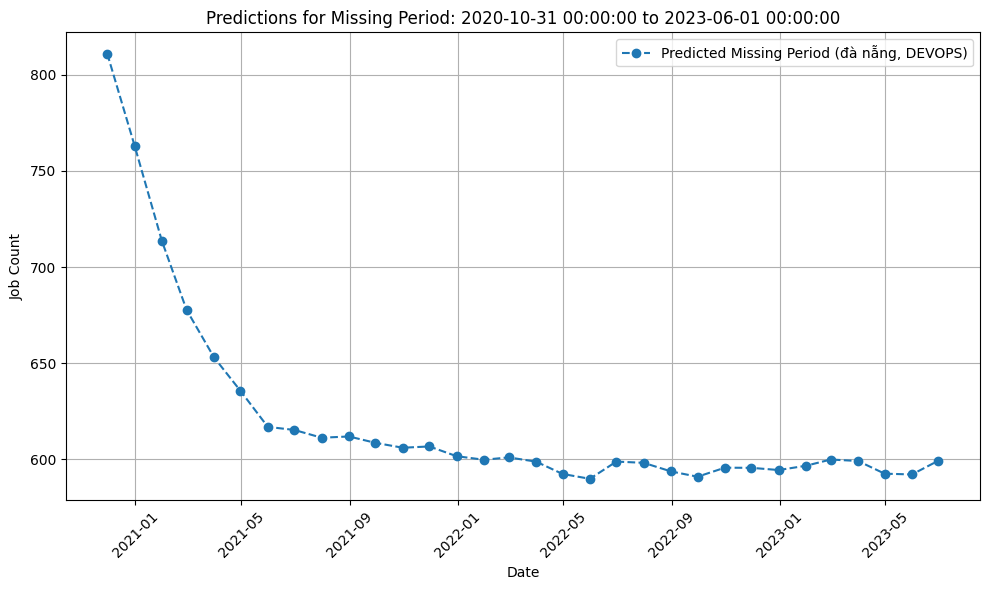

C:\Users\tansa\AppData\Local\Temp\ipykernel_4024\3266537846.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=start_date, periods=steps, freq='M')


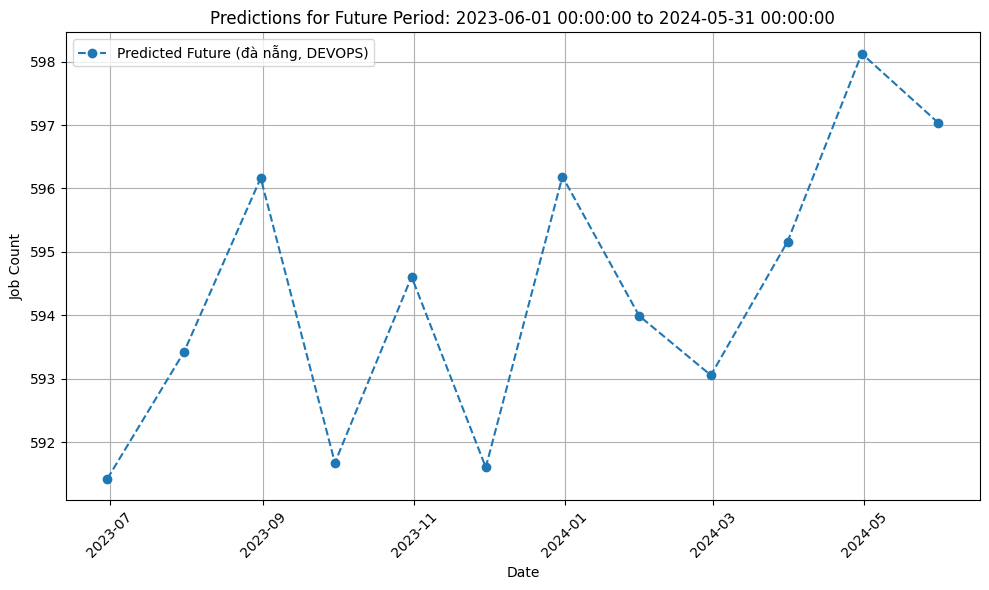

[np.float64(591.4227520011812),
 np.float64(593.4219260813422),
 np.float64(596.1628340634803),
 np.float64(591.6755677434196),
 np.float64(594.6085022406149),
 np.float64(591.6032192542365),
 np.float64(596.1883684672647),
 np.float64(593.9921653652068),
 np.float64(593.0554253038396),
 np.float64(595.1627101827908),
 np.float64(598.1264315769863),
 np.float64(597.0324060567053)]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model
model_path = "D:/SANG/Do An Tot Nghiep/crawl-data/data/DATA PRE-PROCESSING/model/job_trend_forecasting_model.keras"
model = load_model(model_path)

def predict_future(city_name, job_name, start_date, steps=12, add_noise=True):
    print(f"DEBUG: Inputs - City: {city_name}, Job: {job_name}, Start Date: {start_date}, Steps: {steps}")

    city_name = city_name.strip().lower()
    job_name = job_name.strip().upper()

    # Match city & job
    matched_city = next((c for c in city_encoder.categories_[0] if c.strip().lower() == city_name), None)
    matched_job = next((j for j in job_encoder.categories_[0] if j.strip().upper() == job_name), None)

    if matched_city is None or matched_job is None:
        print(f"Error: City '{city_name}' or Job '{job_name}' not found!")
        return

    print("DEBUG: One-hot encoding successful.")

    # Create one-hot vectors
    city_vector = np.zeros(len(city_encoder.categories_[0]))
    city_vector[np.where(city_encoder.categories_[0] == matched_city)[0][0]] = 1

    job_vector = np.zeros(len(job_encoder.categories_[0]))
    job_vector[np.where(job_encoder.categories_[0] == matched_job)[0][0]] = 1

    # **Filter data for the given city & job**
    job_city_filter = (data[f'city_{matched_city}'] == 1) & (data[f'job_{matched_job}'] == 1)
    filtered_data = data[job_city_filter].copy()

    if filtered_data.empty:
        print(f"Error: No historical data found for City '{city_name}' and Job '{job_name}'")
        return

    # Ensure unique timestamps
    filtered_data = filtered_data.groupby(level=0).first()

    # Convert start_date to datetime
    start_date = pd.to_datetime(start_date)

    # **Find closest historical date before start_date**
    filtered_data = filtered_data.sort_index()
    past_data = filtered_data.loc[:start_date]

    if past_data.empty:
        print(f"ERROR: No historical data available before {start_date}. Cannot predict!")
        return

    # **Select the last 'look_back' months before start_date**
    available_data = past_data.iloc[-look_back:].copy()

    # **Fix Missing Data with Interpolation**
    if available_data.shape[0] < look_back:
        print(f"DEBUG: Insufficient data ({available_data.shape[0]} rows), using interpolation.")
        available_data = available_data.resample('M').interpolate(method='linear').iloc[-look_back:]

    print(f"DEBUG: Using {available_data.shape[0]} months of historical data from {available_data.index[0]} to {available_data.index[-1]}")

    # **Normalize historical data**
    available_data[num_cols] = scaler.transform(available_data[num_cols])

    # **Check if there is a gap between the last historical data and start_date**
    last_historical_date = available_data.index[-1]
    if last_historical_date < start_date:
        print(f"DEBUG: Gap detected between {last_historical_date} and {start_date}. Predicting for the missing period.")

        missing_months = (start_date.year - last_historical_date.year) * 12 + (start_date.month - last_historical_date.month)
        missing_dates = pd.date_range(start=last_historical_date + pd.DateOffset(months=1), periods=missing_months, freq='M')
        missing_predictions = []

        batch_sizes = []
        while missing_months > 0:
            if missing_months >= 12:
                batch_sizes.append(12)
                missing_months -= 12
            elif missing_months >= 6:
                batch_sizes.append(6)
                missing_months -= 6
            elif missing_months >= 3:
                batch_sizes.append(3)
                missing_months -= 3
            else:
                batch_sizes.append(missing_months)
                missing_months = 0

        for batch in batch_sizes:
            for _ in range(batch):
                input_data = available_data.values
                input_data = np.expand_dims(input_data, axis=0)

                pred = model.predict(input_data, verbose=0)[0, 0]
                denormalized_pred = scaler.inverse_transform([[pred] + [0] * (len(num_cols) - 1)])[0, 0]

                if add_noise:
                    denormalized_pred += np.random.normal(0, 2)

                missing_predictions.append(denormalized_pred)
                available_data.iloc[:-1] = available_data.iloc[1:].values
                available_data.iloc[-1, 0] = pred

        plt.figure(figsize=(10, 6))
        plt.plot(missing_dates, missing_predictions, marker='o', linestyle='dashed', label=f'Predicted Missing Period ({city_name}, {job_name})')
        plt.xlabel("Date")
        plt.ylabel("Job Count")
        plt.title(f"Predictions for Missing Period: {last_historical_date} to {start_date}")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    predictions = []
    future_dates = pd.date_range(start=start_date, periods=steps, freq='M')
    for _ in range(steps):
        input_data = available_data.values
        input_data = np.expand_dims(input_data, axis=0)

        pred = model.predict(input_data, verbose=0)[0, 0]
        denormalized_pred = scaler.inverse_transform([[pred] + [0] * (len(num_cols) - 1)])[0, 0]

        if add_noise:
            denormalized_pred += np.random.normal(0, 2)

        predictions.append(denormalized_pred)
        available_data.iloc[:-1] = available_data.iloc[1:].values
        available_data.iloc[-1, 0] = pred

    plt.figure(figsize=(10, 6))
    plt.plot(future_dates, predictions, marker='o', linestyle='dashed', label=f'Predicted Future ({city_name}, {job_name})')
    plt.xlabel("Date")
    plt.ylabel("Job Count")
    plt.title(f"Predictions for Future Period: {start_date} to {future_dates[-1]}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return predictions

# Example Usage
predict_future("Đà Nẵng", "DEVOPS", '2023-06', steps=12)

d:\SANG\Do An Tot Nghiep\crawl-data\venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 23 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\tansa\AppData\Local\Temp\ipykernel_4024\3088621517.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  missing_dates = pd.date_range(start=last_historical_date + pd.DateOffset(months=1), periods=missing_months, freq='M')


DEBUG: Inputs - City: Đà Nẵng, Job: JAVA, Start Date: 2024-01, Steps: 12
DEBUG: One-hot encoding successful.
DEBUG: Using 18 months of historical data from 2018-08-31 00:00:00 to 2020-10-31 00:00:00
DEBUG: Gap detected between 2020-10-31 00:00:00 and 2024-01-01 00:00:00. Predicting for the missing period.


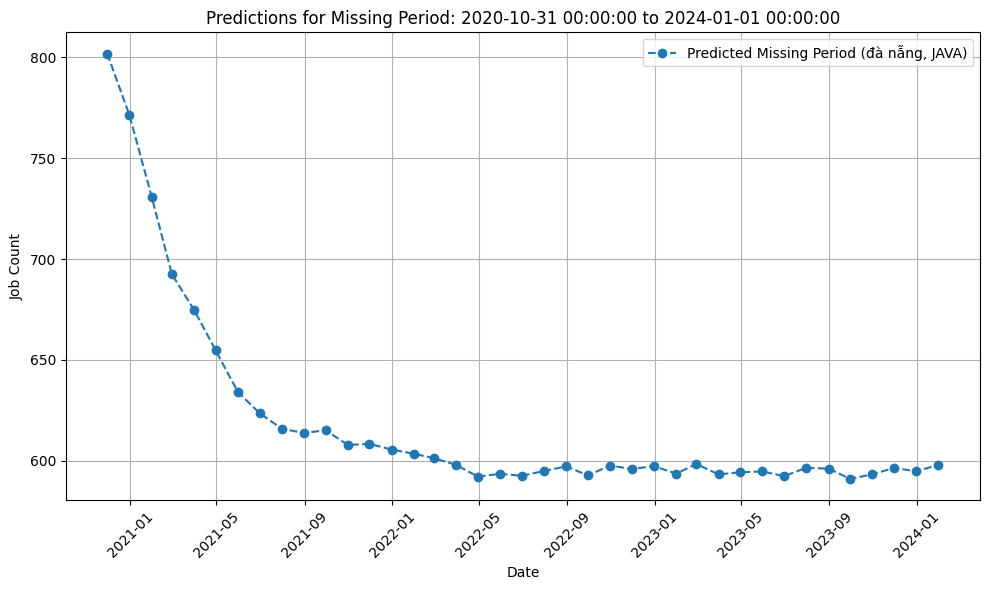

C:\Users\tansa\AppData\Local\Temp\ipykernel_4024\3088621517.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=start_date, periods=steps, freq='M')


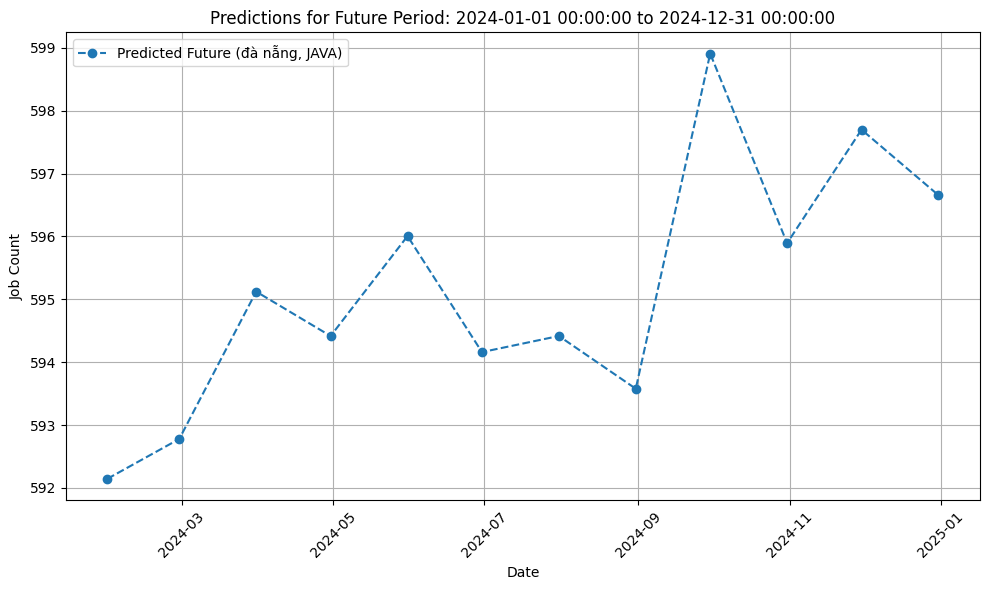

[np.float64(592.1441066993847),
 np.float64(592.7781402834657),
 np.float64(595.121756252842),
 np.float64(594.4153818507395),
 np.float64(596.005375816494),
 np.float64(594.1596286203871),
 np.float64(594.4159240443737),
 np.float64(593.5770801720724),
 np.float64(598.9079929698025),
 np.float64(595.8925281444123),
 np.float64(597.6980509052069),
 np.float64(596.6552491446397)]

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model
model_path = "D:\SANG\Do An Tot Nghiep\crawl-data\data\DATA PRE-PROCESSING\model\job_trend_forecasting_model.keras"
model = load_model(model_path)

def predict_future(city_name, job_name, start_date, steps=12, add_noise=True):
    print(f"DEBUG: Inputs - City: {city_name}, Job: {job_name}, Start Date: {start_date}, Steps: {steps}")

    city_name = city_name.strip().lower()
    job_name = job_name.strip().upper().replace(" ", "")

    # Match city & job
    matched_city = next((c for c in city_encoder.categories_[0] if c.strip().lower() == city_name), None)
    matched_job = next((j for j in job_encoder.categories_[0] if j.replace(" ", "").upper() == job_name), None)

    if matched_city is None or matched_job is None:
        print(f"Error: City '{city_name}' or Job '{job_name}' not found!")
        return

    print("DEBUG: One-hot encoding successful.")

    # Create one-hot vectors
    city_vector = np.zeros(len(city_encoder.categories_[0]))
    city_vector[np.where(city_encoder.categories_[0] == matched_city)[0][0]] = 1

    job_vector = np.zeros(len(job_encoder.categories_[0]))
    job_vector[np.where(job_encoder.categories_[0] == matched_job)[0][0]] = 1

    # **Filter data for the given city & job**
    job_city_filter = (data[f'city_{matched_city}'] == 1) & (data[f'job_{matched_job}'] == 1)
    filtered_data = data[job_city_filter].copy()

    if filtered_data.empty:
        print(f"Error: No historical data found for City '{city_name}' and Job '{job_name}'")
        return

    # Ensure unique timestamps
    filtered_data = filtered_data.groupby(level=0).first()
    filtered_data = filtered_data.sort_index()

    # Convert start_date to datetime
    start_date = pd.to_datetime(start_date)
    past_data = filtered_data.loc[:start_date]

    if past_data.empty:
        print(f"ERROR: No historical data available before {start_date}. Cannot predict!")
        return

    available_data = past_data.iloc[-look_back:].copy()
    if available_data.shape[0] < look_back:
        print(f"DEBUG: Insufficient data ({available_data.shape[0]} rows), using interpolation.")
        available_data = available_data.resample('M').interpolate(method='linear').iloc[-look_back:]

    print(f"DEBUG: Using {available_data.shape[0]} months of historical data from {available_data.index[0]} to {available_data.index[-1]}")
    available_data[num_cols] = scaler.transform(available_data[num_cols])

    last_historical_date = available_data.index[-1]
    if last_historical_date < start_date:
        print(f"DEBUG: Gap detected between {last_historical_date} and {start_date}. Predicting for the missing period.")
        missing_months = (start_date.year - last_historical_date.year) * 12 + (start_date.month - last_historical_date.month)
        missing_dates = pd.date_range(start=last_historical_date + pd.DateOffset(months=1), periods=missing_months, freq='M')

        missing_predictions = []
        batch_sizes = []
        remaining_months = missing_months

        while remaining_months > 0:
            if remaining_months >= 12:
                batch_sizes.append(12)
                remaining_months -= 12
            elif remaining_months >= 6:
                batch_sizes.append(6)
                remaining_months -= 6
            elif remaining_months >= 3:
                batch_sizes.append(3)
                remaining_months -= 3
            else:
                batch_sizes.append(remaining_months)
                remaining_months = 0

        for batch_size in batch_sizes:
            for _ in range(batch_size):
                input_data = available_data.values
                input_data = np.expand_dims(input_data, axis=0)
                pred = model.predict(input_data, verbose=0)[0, 0]
                denormalized_pred = scaler.inverse_transform([[pred] + [0] * (len(num_cols) - 1)])[0, 0]
                if add_noise:
                    denormalized_pred += np.random.normal(0, 2)
                missing_predictions.append(denormalized_pred)
                available_data.iloc[:-1] = available_data.iloc[1:].values
                available_data.iloc[-1, 0] = pred

        plt.figure(figsize=(10, 6))
        plt.plot(missing_dates, missing_predictions, marker='o', linestyle='dashed', label=f'Predicted Missing Period ({city_name}, {job_name})')
        plt.xlabel("Date")
        plt.ylabel("Job Count")
        plt.title(f"Predictions for Missing Period: {last_historical_date} to {start_date}")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    predictions = []
    future_dates = pd.date_range(start=start_date, periods=steps, freq='M')
    for _ in range(steps):
        input_data = available_data.values
        input_data = np.expand_dims(input_data, axis=0)
        pred = model.predict(input_data, verbose=0)[0, 0]
        denormalized_pred = scaler.inverse_transform([[pred] + [0] * (len(num_cols) - 1)])[0, 0]
        if add_noise:
            denormalized_pred += np.random.normal(0, 2)
        predictions.append(denormalized_pred)
        available_data.iloc[:-1] = available_data.iloc[1:].values
        available_data.iloc[-1, 0] = pred

    plt.figure(figsize=(10, 6))
    plt.plot(future_dates, predictions, marker='o', linestyle='dashed', label=f'Predicted Future ({city_name}, {job_name})')
    plt.xlabel("Date")
    plt.ylabel("Job Count")
    plt.title(f"Predictions for Future Period: {start_date} to {future_dates[-1]}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return predictions

# Example Usage
predict_future("Đà Nẵng", "JAVA", '2024-01', steps=12)

d:\SANG\Do An Tot Nghiep\crawl-data\venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 23 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\tansa\AppData\Local\Temp\ipykernel_4024\2272250299.py:74: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  missing_dates = pd.date_range(start=last_historical_date + pd.DateOffset(months=1), periods=missing_months, freq='M')


DEBUG: Inputs - City: Đà Nẵng, Job: FRONTEND, Start Date: 2024-01, Steps: 12
DEBUG: One-hot encoding successful.
DEBUG: Using 18 months of historical data from 2018-08-31 00:00:00 to 2020-09-30 00:00:00
DEBUG: Gap detected between 2020-09-30 00:00:00 and 2024-01-01 00:00:00. Predicting for the missing period.


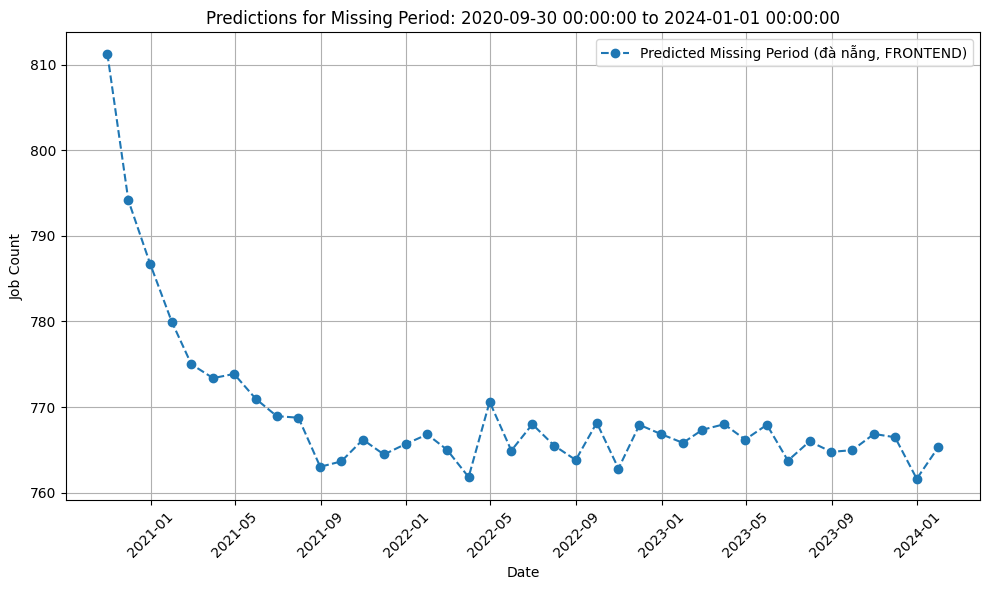

C:\Users\tansa\AppData\Local\Temp\ipykernel_4024\2272250299.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=start_date, periods=steps, freq='M')


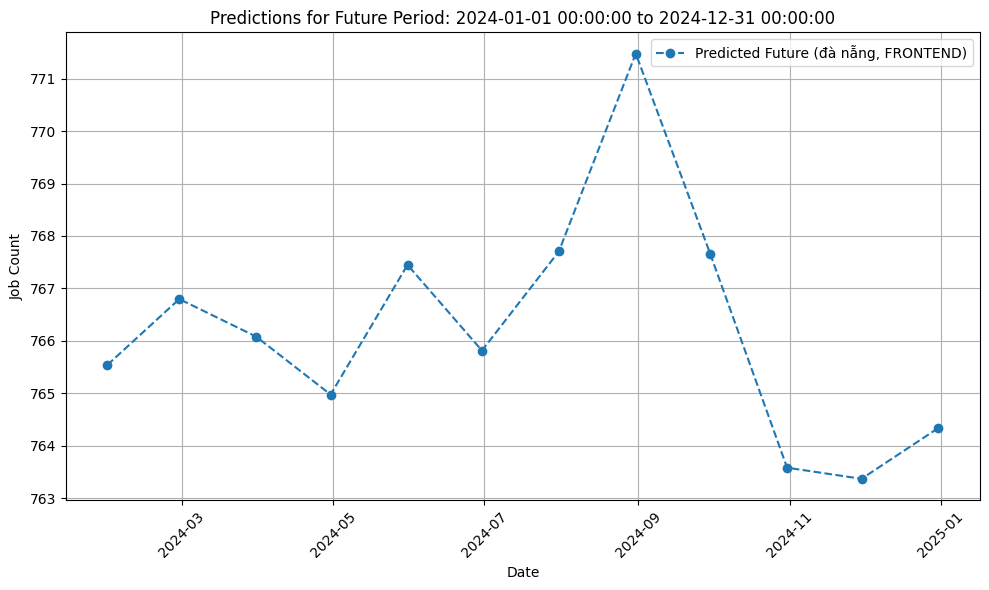

[np.float64(765.5389376396669),
 np.float64(766.796474594351),
 np.float64(766.0797032211788),
 np.float64(764.9749091467005),
 np.float64(767.4481107247536),
 np.float64(765.8133545154313),
 np.float64(767.70462247375),
 np.float64(771.4783241490517),
 np.float64(767.6602450659192),
 np.float64(763.5799834425974),
 np.float64(763.3675812770745),
 np.float64(764.3378702859133)]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model
model_path = "D:/SANG/Do An Tot Nghiep/crawl-data/data/DATA PRE-PROCESSING/model/job_trend_forecasting_model.keras"
model = load_model(model_path)

def predict_future(city_name, job_name, start_date, steps=12, add_noise=True):
    print(f"DEBUG: Inputs - City: {city_name}, Job: {job_name}, Start Date: {start_date}, Steps: {steps}")

    city_name = city_name.strip().lower()
    job_name = job_name.strip().upper()

    # Match city & job
    matched_city = next((c for c in city_encoder.categories_[0] if c.strip().lower() == city_name), None)
    matched_job = next((j for j in job_encoder.categories_[0] if j.strip().upper() == job_name), None)

    if matched_city is None or matched_job is None:
        print(f"Error: City '{city_name}' or Job '{job_name}' not found!")
        return

    print("DEBUG: One-hot encoding successful.")

    # Create one-hot vectors
    city_vector = np.zeros(len(city_encoder.categories_[0]))
    city_vector[np.where(city_encoder.categories_[0] == matched_city)[0][0]] = 1

    job_vector = np.zeros(len(job_encoder.categories_[0]))
    job_vector[np.where(job_encoder.categories_[0] == matched_job)[0][0]] = 1

    # **Filter data for the given city & job**
    job_city_filter = (data[f'city_{matched_city}'] == 1) & (data[f'job_{matched_job}'] == 1)
    filtered_data = data[job_city_filter].copy()

    if filtered_data.empty:
        print(f"Error: No historical data found for City '{city_name}' and Job '{job_name}'")
        return

    # Ensure unique timestamps
    filtered_data = filtered_data.groupby(level=0).first()

    # Convert start_date to datetime
    start_date = pd.to_datetime(start_date)

    # **Find closest historical date before start_date**
    filtered_data = filtered_data.sort_index()
    past_data = filtered_data.loc[:start_date]

    if past_data.empty:
        print(f"ERROR: No historical data available before {start_date}. Cannot predict!")
        return

    # **Select the last 'look_back' months before start_date**
    available_data = past_data.iloc[-look_back:].copy()

    # **Fix Missing Data with Interpolation**
    if available_data.shape[0] < look_back:
        print(f"DEBUG: Insufficient data ({available_data.shape[0]} rows), using interpolation.")
        available_data = available_data.resample('M').interpolate(method='linear').iloc[-look_back:]

    print(f"DEBUG: Using {available_data.shape[0]} months of historical data from {available_data.index[0]} to {available_data.index[-1]}")

    # **Normalize historical data**
    available_data[num_cols] = scaler.transform(available_data[num_cols])

    # **Check if there is a gap between the last historical data and start_date**
    last_historical_date = available_data.index[-1]
    if last_historical_date < start_date:
        print(f"DEBUG: Gap detected between {last_historical_date} and {start_date}. Predicting for the missing period.")

        missing_months = (start_date.year - last_historical_date.year) * 12 + (start_date.month - last_historical_date.month)
        missing_dates = pd.date_range(start=last_historical_date + pd.DateOffset(months=1), periods=missing_months, freq='M')
        missing_predictions = []

        batch_sizes = []
        while missing_months > 0:
            if missing_months >= 12:
                batch_sizes.append(12)
                missing_months -= 12
            elif missing_months >= 6:
                batch_sizes.append(6)
                missing_months -= 6
            elif missing_months >= 3:
                batch_sizes.append(3)
                missing_months -= 3
            else:
                batch_sizes.append(missing_months)
                missing_months = 0

        for batch in batch_sizes:
            for _ in range(batch):
                input_data = available_data.values
                input_data = np.expand_dims(input_data, axis=0)

                pred = model.predict(input_data, verbose=0)[0, 0]
                denormalized_pred = scaler.inverse_transform([[pred] + [0] * (len(num_cols) - 1)])[0, 0]

                if add_noise:
                    denormalized_pred += np.random.normal(0, 2)

                missing_predictions.append(denormalized_pred)
                available_data.iloc[:-1] = available_data.iloc[1:].values
                available_data.iloc[-1, 0] = pred

        plt.figure(figsize=(10, 6))
        plt.plot(missing_dates, missing_predictions, marker='o', linestyle='dashed', label=f'Predicted Missing Period ({city_name}, {job_name})')
        plt.xlabel("Date")
        plt.ylabel("Job Count")
        plt.title(f"Predictions for Missing Period: {last_historical_date} to {start_date}")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    predictions = []
    future_dates = pd.date_range(start=start_date, periods=steps, freq='M')
    for _ in range(steps):
        input_data = available_data.values
        input_data = np.expand_dims(input_data, axis=0)

        pred = model.predict(input_data, verbose=0)[0, 0]
        denormalized_pred = scaler.inverse_transform([[pred] + [0] * (len(num_cols) - 1)])[0, 0]

        if add_noise:
            denormalized_pred += np.random.normal(0, 2)

        predictions.append(denormalized_pred)
        available_data.iloc[:-1] = available_data.iloc[1:].values
        available_data.iloc[-1, 0] = pred

    plt.figure(figsize=(10, 6))
    plt.plot(future_dates, predictions, marker='o', linestyle='dashed', label=f'Predicted Future ({city_name}, {job_name})')
    plt.xlabel("Date")
    plt.ylabel("Job Count")
    plt.title(f"Predictions for Future Period: {start_date} to {future_dates[-1]}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return predictions

# Example Usage
predict_future("Đà Nẵng", "FRONTEND", '2024-01', steps=12)